In [45]:
"""
AI Usage Statement (Craig Woolley)
Tools Used: Gemini
    - Usage: Code for handling infinite values and NaN, Model architecture, understanding compiling model, evaluating performance
    - Verification: Code are manually written
Prohibited Use Compliance: Confirmed

"""

'\nAI Usage Statement (Craig Woolley)\nTools Used: Gemini\n    - Usage: Code for handling infinite values and NaN, Model architecture, understanding compiling model, evaluating performance\n    - Verification: Code are manually written\nProhibited Use Compliance: Confirmed\n\n'

In [46]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from keras import layers, losses, datasets, models



In [ ]:
"""
Load and preprocess data 
"""

# sepcify the file path for the processed data
DATA_DIR = "./processed_data"
# get the processed data X_train, X_val, X_test, y_test
train_df = pd.read_csv(f"{DATA_DIR}/X_train.csv")
val_df   = pd.read_csv(f"{DATA_DIR}/X_val.csv")
test_df  = pd.read_csv(f"{DATA_DIR}/X_test.csv")
y_test   = pd.read_csv(f"{DATA_DIR}/y_test.csv").iloc[:, 0]

# convert the test labels into a binary format 0 for benign and 1 for attack
y_test_bin = (y_test != "Benign").astype(int).values   
# seperate the benign sampels from the training and validaion datasets
train_benign = train_df[train_df["Label"] == "Benign"]
val_benign   = val_df  [val_df  ["Label"] == "Benign"]
# remove the label column and extract only the features into numpy arrays
X_train_raw = train_benign.drop(columns=["Label"]).values
X_val_raw   = val_benign.drop(columns=["Label"]).values
X_test_raw  = test_df.values

In [ ]:
""" 
Impute missing values in the training set using the median of each column
"""

print("Handle infinite values")
# replace any infinite values with nan
# Simple IMputer cannot handle inf but it can handle nan
X_train_raw[np.isinf(X_train_raw)] = np.nan
X_val_raw[np.isinf(X_val_raw)] = np.nan
X_test_raw[np.isinf(X_test_raw)] = np.nan
# use simpleimputer function to replace missing values with the median value of each column
imp = SimpleImputer(strategy="median").fit(X_train_raw)
# use imputer on train, validatoin, and test
X_train_imp = imp.transform(X_train_raw)
X_val_imp   = imp.transform(X_val_raw)
X_test_imp  = imp.transform(X_test_raw)




Handle infinite values


In [ ]:
"""
Normalize features across train, validation, and test datasets using MinMaxScaler function
"""

# Use scaler to learn the min max values but only for the training data
scaler = MinMaxScaler().fit(X_train_imp)
X_train = X_train_imp
X_val   = X_val_imp
X_test  = X_test_imp
print(f"Train shape: {X_train.shape}   Val: {X_val.shape}   Test: {X_test.shape}")
scaler = MinMaxScaler()
scaler.fit(X_train)
# transform the rest of the datasets using the same MinMaxScaler
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# output the scaled ranges to confirm it's working properly
print(f"X_train_scaled range: {X_train_scaled.min()} to {X_train_scaled.max()}")
print(f"X_val_scaled range:   {X_val_scaled.min()} to {X_val_scaled.max()}")
print(f"X_test_scaled range:  {X_test_scaled.min()} to {X_test_scaled.max()}")

Train shape: (204896, 79)   Val: (8882, 79)   Test: (118585, 79)
X_train_scaled range: 0.0 to 1.0000000000000002
X_val_scaled range:   0.0 to 1.0429159883594235
X_test_scaled range:  0.0 to 2.9848533677086695


In [ ]:
"""
Define the architecture for the autoencoder using adam optimizer 
"""
# Get the number of features from the scaled data in our case it was 62
input_dim = X_train_scaled.shape[1]

# Define the bottleneck size 
# this can be changed in hyperparameter tuning
# compress from 62 to 32 features
encoding_dim = 12
# print out both feature sizes to see 
print(f"Input dimension: {input_dim}")
print(f"Encoding dimension: {encoding_dim}")

# define the autoencoder using Keras squential 
autoencoder = keras.Sequential(
    [
        # define the input shape in for the first layer must match the number of input features 
        layers.Input(shape=(input_dim,)),
        # encoder we can add layers or change neuron counts in hyperparameter tuning
        layers.Dense(64, activation="relu"),
        layers.Dense(48, activation="relu"),
        layers.Dense(24, activation="relu"),
        # the bottleneck
        layers.Dense(encoding_dim, activation="relu"),
        # decoder starts here basically same as the encoder just backwards 
        layers.Dense(24, activation="relu"),
        layers.Dense(48, activation="relu"),
        layers.Dense(64, activation="relu"),
        # final layer attempt to reconstruct orgininal input 
        layers.Dense(input_dim, activation="sigmoid")
    ],
    # give the model a name to reference later
    name="autoencoder"
)

# show the architecture of the model 
print("\nModel Summary:")
autoencoder.summary()



Input dimension: 79
Encoding dimension: 12

Model Summary:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 64)             │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 24)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 48)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 79)             │         5,135 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,499 (76.17 KB)

 Trainable params: 19,499 (76.17 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
"""
This block compiles the model defined above
"""
# choose an optimizer 
optimizer = 'adam'

# choose a loss funciton use mse here could also use binary_crossentropy
loss_function = 'mse'

print(f"Compiling model with optimizer='{optimizer}' and loss ='{loss_function}'")

#compile the autoencoder
autoencoder.compile(optimizer=optimizer, loss=loss_function)

print("Success!")


Compiling model with optimizer='adam' and loss ='mse'
Success!


In [ ]:
""" 
This block defines the number of epochs and batch size then trains the model
"""
# define hyperparameters 
num_epochs = 50
batch_size = 32
# this object will store the loss values for each epoch which can be got using 
# history.history['loss'] and history.history['val_loss']
history = autoencoder.fit(
    X_train_scaled, 
    X_train_scaled, 
    epochs=num_epochs, 
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_val_scaled, X_val_scaled) 
)

print("Training of model complete!")

Epoch 1/50
6403/6403 ━━━━━━━━━━━━━━━━━━━━ 3s 386us/step - loss: 0.0119 - val_loss: 0.0010
Epoch 2/50
6403/6403 ━━━━━━━━━━━━━━━━━━━━ 2s 387us/step - loss: 9.0745e-04 - val_loss: 4.0925e-04
Epoch 3/50
6403/6403 ━━━━━━━━━━━━━━━━━━━━ 2s 372us/step - loss: 4.1592e-04 - val_loss: 3.2771e-04
Epoch 4/50
6403/6403 ━━━━━━━━━━━━━━━━━━━━ 2s 377us/step - loss: 3.2706e-04 - val_loss: 2.9344e-04
Epoch 5/50
6403/6403 ━━━━━━━━━━━━━━━━━━━━ 2s 385us/step - loss: 2.8489e-04 - val_loss: 2.4012e-04
Epoch 6/50
6403/6403 ━━━━━━━━━━━━━━━━━━━━ 2s 383us/step - loss: 2.5416e-04 - val_loss: 2.0362e-04
Epoch 7/50
6403/6403 ━━━━━━━━━━━━━━━━━━━━ 2s 382us/step - loss: 2.0361e-04 - val_loss: 1.7612e-04
Epoch 8/50
6403/6403 ━━━━━━━━━━━━━━━━━━━━ 2s 381us/step - loss: 2.0121e-04 - val_loss: 1.8511e-04
Epoch 9/50
6403/6403 ━━━━━━━━━━━━━━━━━━━━ 2s 379us/step - loss: 1.8369e-04 - val_loss: 1.8831e-04
Epoch 10/50
6403/6403 ━━━━━━━━━━━━━━━━━━━━ 2s 380us/step - loss: 1.7697e-04 - val_loss: 1.6134e-04
Epoch 11/50
6403/6403 ━━━━━

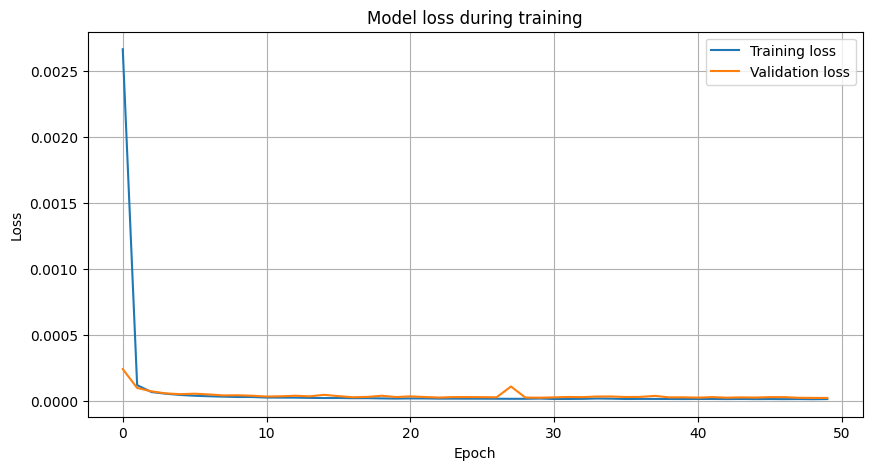

In [ ]:
"""
This block plots the models training and validation loss 
"""
# get the history from the history object defined in the cell above
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(num_epochs)

# plot the training and validation loss using matplot
plt.figure(figsize=(10,5))
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Validation loss')
plt.title('Model loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


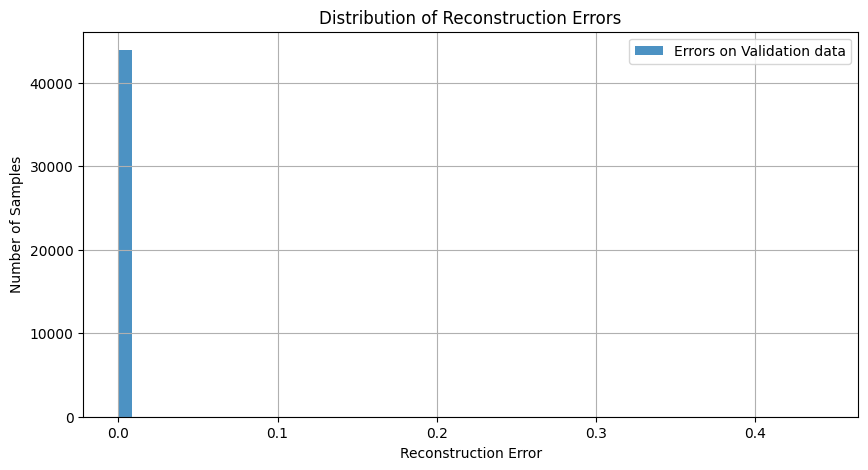

Chosen anomaly threshold (95th percentile of val errors): 0.000026


In [ ]:
"""
This block reconstructs the validation data and determines the error 
then determines whether or not it is above the sepcified threshold
"""
# reconstruct the validation data
reconstruct_val = autoencoder.predict(X_val_scaled)
# determine the reconstruction error for each val sample
val_errors = np.mean(np.power(X_val_scaled - reconstruct_val, 2), axis=1)

# plot the errors on validation data
plt.figure(figsize=(10,5))
plt.hist(val_errors, bins=50, alpha=0.8, label='Errors on Validation data')
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Samples")
plt.title("Distribution of Reconstruction Errors")
plt.legend()
plt.grid(True)
plt.show()

# Determine the threshold with a percentile 
percentile = 99
threshold = np.percentile(val_errors, percentile)

print(f"Chosen anomaly threshold ({percentile}th percentile of val errors): {threshold:.6f}")


In [ ]:
"""
This block evaluates the models performance
"""
# reconstruct the test data set
reconstruct_test = autoencoder.predict(X_test_scaled)

# determine the reconstruction error for each test sample
test_errors = np.mean(np.power(X_test_scaled - reconstruct_test, 2), axis=1)

# predict based on the threshold
y_pred = (test_errors > threshold).astype(int)

# prepare the labels for the benign samples 
y_test_benign = np.where(y_test == 'Benign', 0, 1)

# calculate and display metrics
print(" Evaluation Metrics ")
print(f"Anomaly threshold: {threshold:.6f}")

accuracy = accuracy_score(y_test_benign, y_pred)
precision = precision_score(y_test_benign, y_pred)
recall = recall_score(y_test_benign, y_pred)
f1 = f1_score(y_test_benign, y_pred)

# output the metrics 
print(f"Accuracy: {accuracy:.4f}")
print(f"Precission: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# show the classification report
print("Classification Report: ")
print(classification_report(y_test_benign, y_pred, target_names=['Benign', 'Bot']))

print("Confusion Matrix: ")
confusion_matrix = confusion_matrix(y_test_benign, y_pred)
print(confusion_matrix)




5948/5948 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
 Evaluation Metrics 
Anomaly threshold: 0.000026
Accuracy: 0.2244
Precission: 0.3058
Recall: 0.0065
F1-Score: 0.0128
Classification Report: 
              precision    recall  f1-score   support

      Benign       0.22      0.95      0.36     43921
         Bot       0.31      0.01      0.01    146402

    accuracy                           0.22    190323
   macro avg       0.26      0.48      0.19    190323
weighted avg       0.29      0.22      0.09    190323

Confusion Matrix: 
[[ 41751   2170]
 [145446    956]]
